|  |  |
| ----------- | ----------- |
| Author:| Benjamin Stepin |
| Affiliation:| IMOS-AODN |
| e-mail:| benjamin.stepin@utas.edu.au |
| Date of creation:| 9th May., 2024|


## Required packages

- xarray==2024.3.0
- pandas==2.2.2
- s3fs==2024.3.1
- mplcursors==0.5.3
- cartopy==0.23.0
- matplotlib==3.8.4
- ipympl==0.9.4 (this is for the #matplotlib functionality)

In [14]:
#this adds functionality for zooming in on data on the map.
%matplotlib widget 

import pandas as pd
import xarray as xr
import mplcursors
import s3fs
import os

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Create Functions

### load_wod_data()
This creates a function that can be called for any country or year. The keyboard inputs are year in format YYYY, and country in form string. (can handle spaces) up to 15 chars. eg "united states" not "united states of america"

### plot_wod_map()
This function plots the extracted data onto a map in order to visualise where the datasets are

In [22]:
def load_wod_data(year, country=None):
    dfs = []

    # Path to the WOD s3 bucket (this is an open bucket)
    s3_path = f's3://noaa-wod-pds/{year}/'

    # List all files in the S3 directory
    fs = s3fs.S3FileSystem(anon=True)
    files = fs.ls(s3_path)

    # Iterate through each file in the directory to combine all datasets for a particular year and country
    for file in files:
        # Check if the file matches the pattern 'wod_xxx_YYYY.nc'
        if os.path.basename(file).startswith(f'wod_') and os.path.basename(file).endswith(f'_{year}.nc'):
            with fs.open(file, 'rb') as f:
                ds = xr.open_dataset(f)

                # In this case we're interested in the country, what type of dataset it is (eg, xbt), lat lon and date
                variables = ['Access_no', 'Project', 'country', 'dataset', 'lat', 'lon', 'date']

                # Check if 'Institute' exists in the dataset so we know which institute is respoonsible for the dataset, not not all WOD files have this variable.
                if 'Institute' in ds.variables:
                    variables.append('Institute')

                df = ds[variables].to_dataframe()
                if 'time' in df.columns:
                    df.drop(columns=['time'], inplace=True)

                # All the variables come through as byte strings so we need to decode this to readable formad
                for col in df.columns:
                    if isinstance(df[col][0], bytes):
                        df[col] = df[col].str.decode('utf-8')

                # Add the 'year' column with the value from the file name
                df.insert(0, 'year', int(year))

                # Filter data by country if specified
                if country is not None:
                    df = df[df['country'].str.upper() == country.upper()]

                # Append the DataFrame to the list
                dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)
    
    return combined_df

def plot_wod_map(df):
    # Format desired_country with first letter uppercase and the rest lowercase
    formatted_country = desired_country.capitalize()

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Define the map projection
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot coastlines
    ax.coastlines()

    # Define unique dataset types
    dataset_types = df['dataset'].unique()

    # Define colors for each dataset type
    colors = plt.cm.tab10.colors[:len(dataset_types)]

    scatter_plots = []  # Collect scatter plots here

    # Plot data points for each dataset type
    for i, dataset_type in enumerate(dataset_types):
        dataset_df = df[df['dataset'] == dataset_type]
        scatter = ax.scatter(dataset_df['lon'], dataset_df['lat'], transform=ccrs.PlateCarree(), s=10, color=colors[i], label=dataset_type)
        scatter_plots.append(scatter)  # Add scatter plot to the list

    # Add gridlines
    ax.gridlines(draw_labels=True)

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)

    # Add title and labels
    ax.set_title(f'WOD data from {formatted_country} for {desired_year}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Enable click functionality for all scatter plots
    mplcursors.cursor(scatter_plots).connect("add", lambda sel: sel.annotation.set_text(df.iloc[sel.target.index]))

    # Show the plot
    plt.show()


## Check WOD for data products

In [23]:
# Example usage:
desired_year = input("Enter the desired year: ")
desired_country = input("Enter the desired country (leave blank for all countries): ").upper()
dataframe = load_wod_data(desired_year, country=desired_country)
print(dataframe)

Enter the desired year:  2017
Enter the desired country (leave blank for all countries):  australia


        year  Access_no                                    Project    country  \
0       2017   131830.0  INTEGRATED MARINE OBSERVING SYSTEM (IMOS)  AUSTRALIA   
1       2017   131830.0  INTEGRATED MARINE OBSERVING SYSTEM (IMOS)  AUSTRALIA   
2       2017   131830.0  INTEGRATED MARINE OBSERVING SYSTEM (IMOS)  AUSTRALIA   
3       2017   131830.0  INTEGRATED MARINE OBSERVING SYSTEM (IMOS)  AUSTRALIA   
4       2017   131830.0  INTEGRATED MARINE OBSERVING SYSTEM (IMOS)  AUSTRALIA   
...      ...        ...                                        ...        ...   
102375  2017   175421.0                                             AUSTRALIA   
102376  2017   175421.0                                             AUSTRALIA   
102377  2017   175421.0                                             AUSTRALIA   
102378  2017   175421.0                                             AUSTRALIA   
102379  2017   175421.0                                             AUSTRALIA   

               dataset     

## Plot the data on a world map

This is an interactive map to identify particular casts from the WOD.

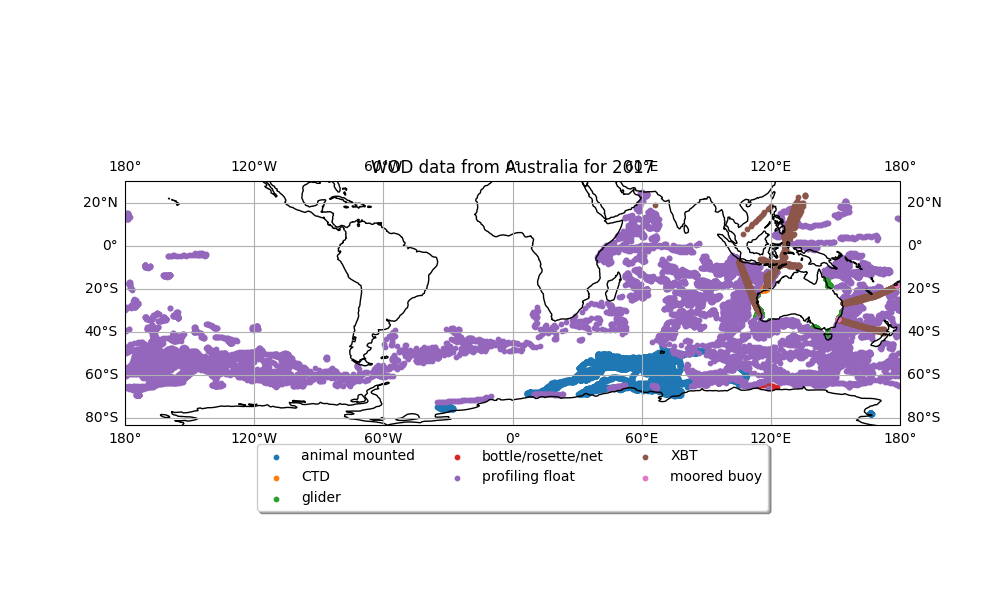

In [24]:

plot_wod_map(dataframe)